In [115]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.stats as scist

from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

from rl import Rollout

# Playground

Below is to test how to do validation and training for policy evaluation.

In [162]:
def get_rollout_object():
    env = gym.make(
        "LunarLander-v2", 
    )
    
    gamma = 0.99
    rollout = Rollout(env, gamma=gamma)
    return env, rollout

### Warm up

In [164]:
n_steps = 4096
(env, rollout) = get_rollout_object()

s, info = env.reset()
for t in range(n_steps):
    a = env.action_space.sample()
    (s_next, r, term, trunc, info) = env.step(a)
    rollout.add_step_data(s,a,r,term or trunc)
    s = s_next

    if term or trunc:
        s,_ = env.reset()

# this is training data
(q_est, adv_est, s_visited, a_visited) = rollout.get_est_stateaction_value()

In [165]:
# simple data analysis
act_mode = scist.mode(np.squeeze(a_visited))

/tmp/ipykernel_13760/1328003038.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  act_mode = scist.mode(np.squeeze(a_visited))


### SGD with validation

In [166]:
import sklearn.pipeline
import sklearn.preprocessing 
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

In [167]:
# initialize
featurizer = PolynomialFeatures(1)
featurizer = RBFSampler(gamma=1.0, n_components=100)

# warm up
n_warmup_steps = 100
X = np.atleast_2d(np.array([env.observation_space.sample() for _ in range(n_warmup_steps)])).T
featurizer.fit(X)

RBFSampler()

In [259]:
def custom_SGD(solver, X, y):
    n_epochs = 200
    frac_val = 0.1
    minibatch = 64
    tol = 1e-3
    max_consec_regree_epochs = 5
    n_consec_regress_epochs = 0
    
    train_losses = []
    test_losses = []
    
    for i in range(n_epochs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i, shuffle=True, test_size=frac_val)
        num_batches = int(np.ceil(len(X_train)/ minibatch))
        for j in range(num_batches):
            k_s = minibatch*j
            k_e = min(len(X_train), minibatch*(j+1))
            # mini-batch update
            solver.partial_fit(X_train[k_s:k_e], y_train[k_s:k_e])

        y_train_pred = solver.predict(X_train)
        y_test_pred = solver.predict(X_test)

        train_losses.append(la.norm(y_train_pred - y_train)**2/len(y_train))
        test_losses.append(la.norm(y_test_pred - y_test)**2/len(y_test))

        if len(test_losses) > 1 and test_losses[-1] > (1.+tol)*test_losses[-2]:
            n_consec_regress_epochs += 1
        else:
            n_consec_regress_epochs = 0
        if n_consec_regress_epochs == max_consec_regree_epochs:
            print("Early stopping")
            break

    return np.array(train_losses), np.array(test_losses)

In [269]:
idx_with_mode = np.where(np.squeeze(a_visited) == act_mode)[1]
featurizer = RBFSampler(gamma=1.0, n_components=100)
featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
    ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
    ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
    ("rbf4", RBFSampler(gamma=0.5, n_components=100)),
    ("rbf5", RBFSampler(gamma=0.1, n_components=100)),
    ("rbf6", RBFSampler(gamma=10., n_components=100)),
    ("rbf7", RBFSampler(gamma=25., n_components=100)),
    ("rbf8", RBFSampler(gamma=0.01, n_components=100)),
])
X = featurizer.fit_transform(s_visited[idx_with_mode])
y = q_est[idx_with_mode]
solver = SGDRegressor(max_iter=200, tol=1e-3, learning_rate="constant", eta0=0.01)

# train
# train_losses, test_losses = custom_SGD(solver, X, y)

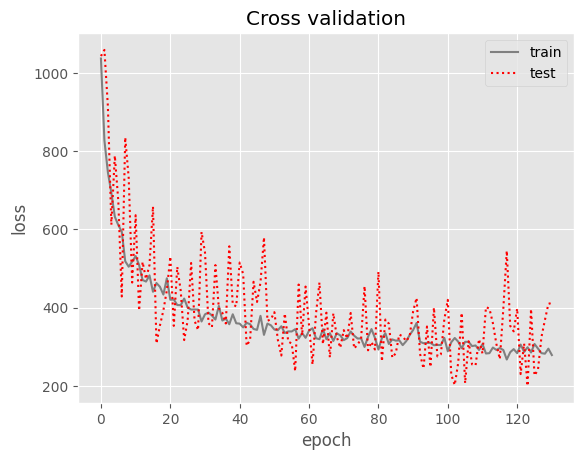

In [263]:
plt.style.use('ggplot')
_, ax = plt.subplots()

ax.plot(np.arange(len(train_losses)), train_losses, label="train", color="gray")
ax.plot(np.arange(len(test_losses)), test_losses, label="test", linestyle="dotted", color="red")
ax.set(xlabel="epoch", ylabel="loss", title="Cross validation")
ax.legend()

In [272]:
a = solver.fit(X, y)
print(la.norm(solver.predict(X)-y)**2/len(y))

295.6608181766516
